## Bundesliga bet predictor

In [1]:
import requests
import json
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix

from IPython.display import display
%matplotlib inline

# ML:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

# discriminative classifier formally defined by a separating hyperplane
from sklearn.svm import SVC

# produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
# the outcome (dependent variable) has only a limited number of possible values.
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier



# Get data and cleaning them

In [2]:
# Table on season 2021/2022
link = 'https://www.openligadb.de/api/getbltable/bl1/2021'
response = requests.get(link)
t_2021 = response.json()

In [3]:
# should be 18 teams per season
df = pd.DataFrame(t_2021)

In [4]:
df.dtypes

TeamInfoId        int64
TeamName         object
ShortName        object
TeamIconUrl      object
Points            int64
OpponentGoals     int64
Goals             int64
Matches           int64
Won               int64
Lost              int64
Draw              int64
GoalDiff          int64
dtype: object

In [5]:
df = df.drop(['ShortName', 'TeamIconUrl'], axis = 1)
df = df.rename(columns={ "TeamInfoId": "team_id", "TeamName": "team_name", "Points": "points", "OpponentGoals": "opponent_goals", "Goals": "goals", "Matches": "matches", "Won": "won_games", "Lost": "lost_games", "Draw": "draw", "GoalDiff": "goal_diff"})
df.head(18)

,team_id,team_name,points,opponent_goals,goals,matches,won_games,lost_games,draw,goal_diff
0,40,FC Bayern München,77,37,97,34,24,5,5,60
1,7,Borussia Dortmund,69,52,85,34,22,9,3,33
2,6,Bayer Leverkusen,64,47,80,34,19,8,7,33
3,1635,RB Leipzig,58,37,72,34,17,10,7,35
4,80,1. FC Union Berlin,57,44,50,34,16,9,9,6
5,112,SC Freiburg,55,46,58,34,15,9,10,12
6,65,1. FC Köln,52,49,52,34,14,10,10,3
7,81,1. FSV Mainz 05,46,45,50,34,13,14,7,5
8,175,TSG 1899 Hoffenheim,46,60,58,34,13,14,7,-2
9,87,Borussia Mönchengladbach,45,61,54,34,12,13,9,-7


In [6]:
df.insert(10, 'season', link[-4:])

In [7]:
link2 = 'https://www.openligadb.de/api/getbltable/bl1/2020'
link3 = 'https://www.openligadb.de/api/getbltable/bl1/2019'
link4 = 'https://www.openligadb.de/api/getbltable/bl1/2018'
link5 = 'https://www.openligadb.de/api/getbltable/bl1/2017'
link6 = 'https://www.openligadb.de/api/getbltable/bl1/2016'
link7 = 'https://www.openligadb.de/api/getbltable/bl1/2015'
link8 = 'https://www.openligadb.de/api/getbltable/bl1/2014'
link9 = 'https://www.openligadb.de/api/getbltable/bl1/2013'
link10 = 'https://www.openligadb.de/api/getbltable/bl1/2012'

# upcoming season
link11 = 'https://www.openligadb.de/api/getbltable/bl1/2022'

In [8]:
def clean1 (link):
    response = requests.get(link)
    t = response.json()
    df = pd.DataFrame(t)

    df = df.drop(['ShortName', 'TeamIconUrl'], axis = 1)
    df = df.rename(columns={ "TeamInfoId": "team_id", "TeamName": "team_name", "Points": "points", "OpponentGoals": "opponent_goals", "Goals": "goals", "Matches": "matches", "Won": "won_games", "Lost": "lost_games", "Draw": "draw", "GoalDiff": "goal_diff"})
    df.insert(10, 'season', link[-4:])

    return df
    

In [9]:
df2 = clean1 (link2)
df3 = clean1 (link3)
df4 = clean1 (link4)
df5 = clean1 (link5)
df6 = clean1 (link6)
df7 = clean1 (link7)
df8 = clean1 (link8)
df9 = clean1 (link9)
df10 = clean1 (link10)
# upcoming season
#df11 = clean1 (link11)

In [10]:
df_t = pd.concat([df, df2, df3, df4, df5, df6, df7, df8, df9, df10]) #, df11])

In [11]:
df_t.dtypes

team_id            int64
team_name         object
points             int64
opponent_goals     int64
goals              int64
matches            int64
won_games          int64
lost_games         int64
draw               int64
goal_diff          int64
season            object
dtype: object

In [12]:
# df_t = df_t.drop_duplicates(subset=['team_id'], keep='first')


In [13]:
df_t.reset_index()

,index,team_id,team_name,points,opponent_goals,goals,matches,won_games,lost_games,draw,goal_diff,season
0,0,40,FC Bayern München,77,37,97,34,24,5,5,60,2021
1,1,7,Borussia Dortmund,69,52,85,34,22,9,3,33,2021
2,2,6,Bayer Leverkusen,64,47,80,34,19,8,7,33,2021
3,3,1635,RB Leipzig,58,37,72,34,17,10,7,35,2021
4,4,80,1. FC Union Berlin,57,44,50,34,16,9,9,6,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
175,13,134,Werder Bremen,34,66,50,34,8,16,10,-16,2012
176,14,95,FC Augsburg,33,51,33,34,8,17,9,-18,2012
177,15,175,TSG 1899 Hoffenheim,31,67,42,34,8,19,7,-25,2012
178,16,185,Fortuna Düsseldorf,30,57,39,34,7,18,9,-18,2012


In [14]:
#df_t.team_id.unique()

In [15]:
# All game results season 2021/2022

link_r = 'https://www.openligadb.de/api/getmatchdata/bl1/2021'
response = requests.get(link_r)
r_2021 = response.json()

In [16]:
# should be 306 games (=rows) for each season | (18 teams = (17 + 17) * 9)
data = pd.DataFrame(r_2021)
data.tail()

,MatchID,MatchDateTime,TimeZoneID,LeagueId,LeagueName,MatchDateTimeUTC,Group,Team1,Team2,LastUpdateDateTime,MatchIsFinished,MatchResults,Goals,Location,NumberOfViewers
301,61146,2022-05-14T15:30:00,W. Europe Standard Time,4500,1. Fußball-Bundesliga 2021/2022,2022-05-14T13:30:00Z,"{'GroupName': '34. Spieltag', 'GroupOrderID': ...","{'TeamId': 87, 'TeamName': 'Borussia Mönchengl...","{'TeamId': 175, 'TeamName': 'TSG 1899 Hoffenhe...",2022-05-14T17:23:38.417,True,"[{'ResultID': 98141, 'ResultName': 'Endergebni...","[{'GoalID': 94449, 'ScoreTeam1': 0, 'ScoreTeam...",None,NaN
302,61147,2022-05-14T15:30:00,W. Europe Standard Time,4500,1. Fußball-Bundesliga 2021/2022,2022-05-14T13:30:00Z,"{'GroupName': '34. Spieltag', 'GroupOrderID': ...","{'TeamId': 81, 'TeamName': '1. FSV Mainz 05', ...","{'TeamId': 91, 'TeamName': 'Eintracht Frankfur...",2022-05-14T17:31:21.193,True,"[{'ResultID': 98143, 'ResultName': 'Endergebni...","[{'GoalID': 94452, 'ScoreTeam1': 1, 'ScoreTeam...",None,NaN
303,61148,2022-05-14T15:30:00,W. Europe Standard Time,4500,1. Fußball-Bundesliga 2021/2022,2022-05-14T13:30:00Z,"{'GroupName': '34. Spieltag', 'GroupOrderID': ...","{'TeamId': 16, 'TeamName': 'VfB Stuttgart', 'S...","{'TeamId': 65, 'TeamName': '1. FC Köln', 'Shor...",2022-05-14T17:31:24.007,True,"[{'ResultID': 98137, 'ResultName': 'Endergebni...","[{'GoalID': 94453, 'ScoreTeam1': 1, 'ScoreTeam...",None,NaN
304,61149,2022-05-14T15:30:00,W. Europe Standard Time,4500,1. Fußball-Bundesliga 2021/2022,2022-05-14T13:30:00Z,"{'GroupName': '34. Spieltag', 'GroupOrderID': ...","{'TeamId': 80, 'TeamName': '1. FC Union Berlin...","{'TeamId': 129, 'TeamName': 'VfL Bochum', 'Sho...",2022-05-14T17:31:26.883,True,"[{'ResultID': 98131, 'ResultName': 'Endergebni...","[{'GoalID': 94450, 'ScoreTeam1': 1, 'ScoreTeam...",None,NaN
305,61150,2022-05-14T15:30:00,W. Europe Standard Time,4500,1. Fußball-Bundesliga 2021/2022,2022-05-14T13:30:00Z,"{'GroupName': '34. Spieltag', 'GroupOrderID': ...","{'TeamId': 131, 'TeamName': 'VfL Wolfsburg', '...","{'TeamId': 40, 'TeamName': 'FC Bayern München'...",2022-05-14T17:31:33.82,True,"[{'ResultID': 98145, 'ResultName': 'Endergebni...","[{'GoalID': 94455, 'ScoreTeam1': 0, 'ScoreTeam...",None,NaN


In [17]:
# get new columns from columns with a dictionary
def flatten(data, col_list):
    for column in col_list:
        flattened = pd.DataFrame(dict(data[column])).transpose()
        columns = [str(col) for col in flattened.columns]
        flattened.columns = [column + '_' + colname for colname in columns]
        data = pd.concat([data, flattened], axis=1)
        data = data.drop(column, axis=1)
    return data

In [18]:
# unpack dicts
pd.set_option("display.max_columns", 0)

nested_columns = ['Group', 'Team1', 'Team2', 'MatchResults']
flat = flatten(data, nested_columns)

nested_columns2 = ['MatchResults_0', 'MatchResults_1']
flat2 = flatten(flat, nested_columns2)


In [19]:
# drop ueselss columns
s_2021 = flat2.drop(['TimeZoneID', 'LeagueId', 'LeagueName', 'MatchDateTimeUTC', 'LastUpdateDateTime', 'MatchIsFinished', 'Goals', 'Location', 'NumberOfViewers', 'Group_GroupName', 'Group_GroupID', 'Team1_ShortName', 'Team1_TeamIconUrl', 'Team1_TeamGroupName', 'Team1_ShortName', 	'Team1_TeamIconUrl', 'Team1_TeamGroupName', 'MatchResults_0_ResultOrderID', 'MatchResults_0_ResultTypeID', 'MatchResults_0_ResultDescription', 'MatchResults_1_ResultID', 'MatchResults_1_ResultOrderID', 'MatchResults_1_ResultTypeID', 'MatchResults_1_ResultDescription', 'Team2_ShortName', 'Team2_TeamIconUrl', 'Team2_TeamGroupName', 'MatchResults_0_ResultID', 'MatchResults_0_ResultName', 'MatchResults_1_ResultName'], axis = 1)

In [20]:
# check data types of the columns
s_2021.dtypes

MatchID                        int64
MatchDateTime                 object
Group_GroupOrderID            object
Team1_TeamId                  object
Team1_TeamName                object
Team2_TeamId                  object
Team2_TeamName                object
MatchResults_0_PointsTeam1    object
MatchResults_0_PointsTeam2    object
MatchResults_1_PointsTeam1    object
MatchResults_1_PointsTeam2    object
dtype: object

In [21]:
# change date column to weekday: 4=friday, 5=saturday, 6=sunday (most common days!)
s_2021['MatchDateTime'] = pd.to_datetime(s_2021['MatchDateTime'])
s_2021['MatchDateTime'] = s_2021['MatchDateTime'].dt.dayofweek

In [22]:
# change to numeric column if sensful
s_2021['MatchID'] = s_2021['MatchID'].astype(int)
s_2021['Group_GroupOrderID'] = s_2021['Group_GroupOrderID'].astype(int)
s_2021['Team1_TeamId'] = s_2021['Team1_TeamId'].astype(int)
s_2021['Team2_TeamId'] = s_2021['Team2_TeamId'].astype(int)
s_2021['MatchResults_0_PointsTeam1'] = s_2021['MatchResults_0_PointsTeam1'].astype(int)
s_2021['MatchResults_0_PointsTeam2'] = s_2021['MatchResults_0_PointsTeam2'].astype(int)
s_2021['MatchResults_1_PointsTeam1'] = s_2021['MatchResults_1_PointsTeam1'].astype(int)
s_2021['MatchResults_1_PointsTeam2'] = s_2021['MatchResults_1_PointsTeam2'].astype(int)

In [23]:
# rename columns and lower them in this step too
s = s_2021.rename(columns={ "MatchID": "match_id", "MatchDateTime": "weekday", "Group_GroupOrderID": "gameday", "Team1_TeamId": "team1_id", "Team2_TeamId": "team2_id", "Team1_TeamName": "team1_name", "Team2_TeamName": "team2_name", "MatchResults_0_PointsTeam1": "2nd_ht_result_team1", "MatchResults_0_PointsTeam2": "2nd_ht_result_team2", "MatchResults_1_PointsTeam1": "1st_ht_result_team1", "MatchResults_1_PointsTeam2": "1st_ht_result_team2" })

In [24]:
s.insert(11, 'season', link_r[-4:])

In [25]:
# check result
s

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season
0,60845,4,1,87,Borussia Mönchengladbach,40,FC Bayern München,1,1,1,1,2021
1,60846,5,1,83,Arminia Bielefeld,112,SC Freiburg,0,0,0,0,2021
2,60847,5,1,95,FC Augsburg,175,TSG 1899 Hoffenheim,0,4,0,1,2021
3,60851,5,1,16,VfB Stuttgart,115,SpVgg Greuther Fürth,5,1,2,0,2021
4,60852,5,1,80,1. FC Union Berlin,6,Bayer Leverkusen,1,1,1,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
301,61146,5,34,87,Borussia Mönchengladbach,175,TSG 1899 Hoffenheim,5,1,3,1,2021
302,61147,5,34,81,1. FSV Mainz 05,91,Eintracht Frankfurt,2,2,1,2,2021
303,61148,5,34,16,VfB Stuttgart,65,1. FC Köln,2,1,1,0,2021
304,61149,5,34,80,1. FC Union Berlin,129,VfL Bochum,3,2,2,0,2021


In [26]:
def clean_r (link_r):
    response = requests.get(link_r)
    r = response.json()
    data = pd.DataFrame(r)

    nested_columns = ['Group', 'Team1', 'Team2', 'MatchResults']
    flat = flatten(data, nested_columns)
    nested_columns2 = ['MatchResults_0', 'MatchResults_1']
    flat2 = flatten(flat, nested_columns2)

    s = flat2.drop(['TimeZoneID', 'LeagueId', 'LeagueName', 'MatchDateTimeUTC', 'LastUpdateDateTime', 'MatchIsFinished', 'Goals', 'Location', 'NumberOfViewers', 'Group_GroupName', 'Group_GroupID', 'Team1_ShortName', 'Team1_TeamIconUrl', 'Team1_TeamGroupName', 'Team1_ShortName', 	'Team1_TeamIconUrl', 'Team1_TeamGroupName', 'MatchResults_0_ResultOrderID', 'MatchResults_0_ResultTypeID', 'MatchResults_0_ResultDescription', 'MatchResults_1_ResultID', 'MatchResults_1_ResultOrderID', 'MatchResults_1_ResultTypeID', 'MatchResults_1_ResultDescription', 'Team2_ShortName', 'Team2_TeamIconUrl', 'Team2_TeamGroupName', 'MatchResults_0_ResultID', 'MatchResults_0_ResultName', 'MatchResults_1_ResultName'], axis = 1)

    s['MatchDateTime'] = pd.to_datetime(s['MatchDateTime'])
    s['MatchDateTime'] = s['MatchDateTime'].dt.dayofweek

    s['MatchID'] = s['MatchID'].astype(int)
    s['Group_GroupOrderID'] = s['Group_GroupOrderID'].astype(int)
    s['Team1_TeamId'] = s['Team1_TeamId'].astype(int)
    s['Team2_TeamId'] = s['Team2_TeamId'].astype(int)
    s['MatchResults_0_PointsTeam1'] = s['MatchResults_0_PointsTeam1'].astype(int)
    s['MatchResults_0_PointsTeam2'] = s['MatchResults_0_PointsTeam2'].astype(int)
    s['MatchResults_1_PointsTeam1'] = s['MatchResults_1_PointsTeam1'].astype(int)
    s['MatchResults_1_PointsTeam2'] = s['MatchResults_1_PointsTeam2'].astype(int)

    s = s.rename(columns={ "MatchID": "match_id", "MatchDateTime": "weekday", "Group_GroupOrderID": "gameday", "Team1_TeamId": "team1_id", "Team2_TeamId": "team2_id", "Team1_TeamName": "team1_name", "Team2_TeamName": "team2_name", "MatchResults_0_PointsTeam1": "2nd_ht_result_team1", "MatchResults_0_PointsTeam2": "2nd_ht_result_team2", "MatchResults_1_PointsTeam1": "1st_ht_result_team1", "MatchResults_1_PointsTeam2": "1st_ht_result_team2" })

    s.insert(11, 'season', link_r[-4:])
    
    return s

In [27]:
link_r2 = 'https://www.openligadb.de/api/getmatchdata/bl1/2020'
link_r3 = 'https://www.openligadb.de/api/getmatchdata/bl1/2019'
link_r4 = 'https://www.openligadb.de/api/getmatchdata/bl1/2018'
link_r5 = 'https://www.openligadb.de/api/getmatchdata/bl1/2017'
link_r6 = 'https://www.openligadb.de/api/getmatchdata/bl1/2016'
link_r7 = 'https://www.openligadb.de/api/getmatchdata/bl1/2015'
link_r8 = 'https://www.openligadb.de/api/getmatchdata/bl1/2014'
link_r9 = 'https://www.openligadb.de/api/getmatchdata/bl1/2013'
link_r10 = 'https://www.openligadb.de/api/getmatchdata/bl1/2012'

# upcoming season
#link_r11 = 'https://www.openligadb.de/api/getmatchdata/bl1/2022'

In [28]:
s2 = clean_r (link_r2)
s3 = clean_r (link_r3)
s4 = clean_r (link_r4)
s5 = clean_r (link_r5)
s6 = clean_r (link_r6)
s7 = clean_r (link_r7)
s8 = clean_r (link_r8)
s9 = clean_r (link_r9)
s10 = clean_r (link_r10)
# upcoming season
#s11 = clean_r (link_r11)

In [29]:
df_r = pd.concat([s, s2, s3, s4, s5, s6, s7, s8, s9, s10]) #, s11])

In [30]:
df_r

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season
0,60845,4,1,87,Borussia Mönchengladbach,40,FC Bayern München,1,1,1,1,2021
1,60846,5,1,83,Arminia Bielefeld,112,SC Freiburg,0,0,0,0,2021
2,60847,5,1,95,FC Augsburg,175,TSG 1899 Hoffenheim,0,4,0,1,2021
3,60851,5,1,16,VfB Stuttgart,115,SpVgg Greuther Fürth,5,1,2,0,2021
4,60852,5,1,80,1. FC Union Berlin,6,Bayer Leverkusen,1,1,1,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
301,20247,5,34,91,Eintracht Frankfurt,131,VfL Wolfsburg,2,2,1,2,2012
302,20248,5,34,79,1. FC Nürnberg,134,Werder Bremen,0,1,3,2,2012
303,20249,5,34,7,Borussia Dortmund,175,TSG 1899 Hoffenheim,1,2,1,0,2012
304,20250,5,34,16,VfB Stuttgart,81,1. FSV Mainz 05,2,2,2,2,2012


In [31]:
df_r['comp1']= df_r['team1_id'].astype(str) +'_'+ df_r['season']
df_r['comp2']= df_r['team2_id'].astype(str) +'_'+ df_r['season']

df_t['comp']= df_t['team_id'].astype(str) +'_'+ df_t['season']

In [32]:
df_t = df_t.drop(['team_name', 'matches', 'season'], axis = 1)

In [33]:
df_r = pd.merge(left = df_r,
             right = df_t,
             how = 'left', 
             left_on = "comp1", 
             right_on= "comp")

df_r = pd.merge(left = df_r,
             right = df_t,
             how = 'left', 
             left_on = "comp2", 
             right_on= "comp")

In [34]:
df_r

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season,comp1,comp2,team_id_x,points_x,opponent_goals_x,goals_x,won_games_x,lost_games_x,draw_x,goal_diff_x,comp_x,team_id_y,points_y,opponent_goals_y,goals_y,won_games_y,lost_games_y,draw_y,goal_diff_y,comp_y
0,60845,4,1,87,Borussia Mönchengladbach,40,FC Bayern München,1,1,1,1,2021,87_2021,40_2021,87,45,61,54,12,13,9,-7,87_2021,40,77,37,97,24,5,5,60,40_2021
1,60846,5,1,83,Arminia Bielefeld,112,SC Freiburg,0,0,0,0,2021,83_2021,112_2021,83,28,53,27,5,16,13,-26,83_2021,112,55,46,58,15,9,10,12,112_2021
2,60847,5,1,95,FC Augsburg,175,TSG 1899 Hoffenheim,0,4,0,1,2021,95_2021,175_2021,95,38,56,39,10,16,8,-17,95_2021,175,46,60,58,13,14,7,-2,175_2021
3,60851,5,1,16,VfB Stuttgart,115,SpVgg Greuther Fürth,5,1,2,0,2021,16_2021,115_2021,16,33,59,41,7,15,12,-18,16_2021,115,18,82,28,3,22,9,-54,115_2021
4,60852,5,1,80,1. FC Union Berlin,6,Bayer Leverkusen,1,1,1,1,2021,80_2021,6_2021,80,57,44,50,16,9,9,6,80_2021,6,64,47,80,19,8,7,33,6_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,20247,5,34,91,Eintracht Frankfurt,131,VfL Wolfsburg,2,2,1,2,2012,91_2012,131_2012,91,51,46,49,14,11,9,3,91_2012,131,43,52,47,10,11,13,-5,131_2012
3056,20248,5,34,79,1. FC Nürnberg,134,Werder Bremen,0,1,3,2,2012,79_2012,134_2012,79,44,47,39,11,12,11,-8,79_2012,134,34,66,50,8,16,10,-16,134_2012
3057,20249,5,34,7,Borussia Dortmund,175,TSG 1899 Hoffenheim,1,2,1,0,2012,7_2012,175_2012,7,66,42,81,19,6,9,39,7_2012,175,31,67,42,8,19,7,-25,175_2012
3058,20250,5,34,16,VfB Stuttgart,81,1. FSV Mainz 05,2,2,2,2,2012,16_2012,81_2012,16,43,55,37,12,15,7,-18,16_2012,81,42,44,42,10,12,12,-2,81_2012


In [35]:
df_r = df_r.drop(['comp1', 'comp2', 'team_id_x', 'team_id_y', 'comp_x', 'comp_y',], axis = 1)
df_r = df_r.rename(columns={ "points_x": "team1_points", "points_y": "team2_points", "opponent_goals_x": "team1_opponent_goals", "opponent_goals_y": "team2_opponent_goals", "goals_x": "team1_goals", "goals_y": "team2_goals", "won_games_x": "team1_won_games", "won_games_y": "team2_won_games", "lost_games_x": "team1_lost_games", "lost_games_y": "team2_lost_games", "draw_x": "team1_draw", "draw_y": "team2_draw", "goal_diff_x": "team1_goal_diff", "goal_diff_y": "team2_goal_diff"})

In [36]:
df_r['difference_points'] = df_r["team1_points"] - df_r["team2_points"]

In [37]:
# 0 = home team wins | 1 = home team loses | 2 = draw

def res(row):
    if row['2nd_ht_result_team1'] > row['2nd_ht_result_team2']:
        val = 0
    elif row['2nd_ht_result_team1'] < row['2nd_ht_result_team2']:
        val = 1
    else:
        val = 2
    return val

In [38]:
df_r['result'] = df_r.apply(res, axis=1)

In [39]:
df_r

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season,team1_points,team1_opponent_goals,team1_goals,team1_won_games,team1_lost_games,team1_draw,team1_goal_diff,team2_points,team2_opponent_goals,team2_goals,team2_won_games,team2_lost_games,team2_draw,team2_goal_diff,difference_points,result
0,60845,4,1,87,Borussia Mönchengladbach,40,FC Bayern München,1,1,1,1,2021,45,61,54,12,13,9,-7,77,37,97,24,5,5,60,-32,2
1,60846,5,1,83,Arminia Bielefeld,112,SC Freiburg,0,0,0,0,2021,28,53,27,5,16,13,-26,55,46,58,15,9,10,12,-27,2
2,60847,5,1,95,FC Augsburg,175,TSG 1899 Hoffenheim,0,4,0,1,2021,38,56,39,10,16,8,-17,46,60,58,13,14,7,-2,-8,1
3,60851,5,1,16,VfB Stuttgart,115,SpVgg Greuther Fürth,5,1,2,0,2021,33,59,41,7,15,12,-18,18,82,28,3,22,9,-54,15,0
4,60852,5,1,80,1. FC Union Berlin,6,Bayer Leverkusen,1,1,1,1,2021,57,44,50,16,9,9,6,64,47,80,19,8,7,33,-7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,20247,5,34,91,Eintracht Frankfurt,131,VfL Wolfsburg,2,2,1,2,2012,51,46,49,14,11,9,3,43,52,47,10,11,13,-5,8,2
3056,20248,5,34,79,1. FC Nürnberg,134,Werder Bremen,0,1,3,2,2012,44,47,39,11,12,11,-8,34,66,50,8,16,10,-16,10,1
3057,20249,5,34,7,Borussia Dortmund,175,TSG 1899 Hoffenheim,1,2,1,0,2012,66,42,81,19,6,9,39,31,67,42,8,19,7,-25,35,1
3058,20250,5,34,16,VfB Stuttgart,81,1. FSV Mainz 05,2,2,2,2,2012,43,55,37,12,15,7,-18,42,44,42,10,12,12,-2,1,2


# Analyzing

In [40]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = df_r.shape[0]

# Calculate matches won by home team.
n_homewins = len(df_r[df_r.result == 0])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 3060
Number of matches won by home team: 1288
Win rate of home team: 42.09%


In [41]:
df_r.to_excel(r'games_ft.xlsx', index = False)

array([[<AxesSubplot:xlabel='team1_points', ylabel='team1_points'>,
        <AxesSubplot:xlabel='team2_points', ylabel='team1_points'>,
        <AxesSubplot:xlabel='team1_goal_diff', ylabel='team1_points'>,
        <AxesSubplot:xlabel='team2_goal_diff', ylabel='team1_points'>,
        <AxesSubplot:xlabel='difference_points', ylabel='team1_points'>],
       [<AxesSubplot:xlabel='team1_points', ylabel='team2_points'>,
        <AxesSubplot:xlabel='team2_points', ylabel='team2_points'>,
        <AxesSubplot:xlabel='team1_goal_diff', ylabel='team2_points'>,
        <AxesSubplot:xlabel='team2_goal_diff', ylabel='team2_points'>,
        <AxesSubplot:xlabel='difference_points', ylabel='team2_points'>],
       [<AxesSubplot:xlabel='team1_points', ylabel='team1_goal_diff'>,
        <AxesSubplot:xlabel='team2_points', ylabel='team1_goal_diff'>,
        <AxesSubplot:xlabel='team1_goal_diff', ylabel='team1_goal_diff'>,
        <AxesSubplot:xlabel='team2_goal_diff', ylabel='team1_goal_diff'>,
      

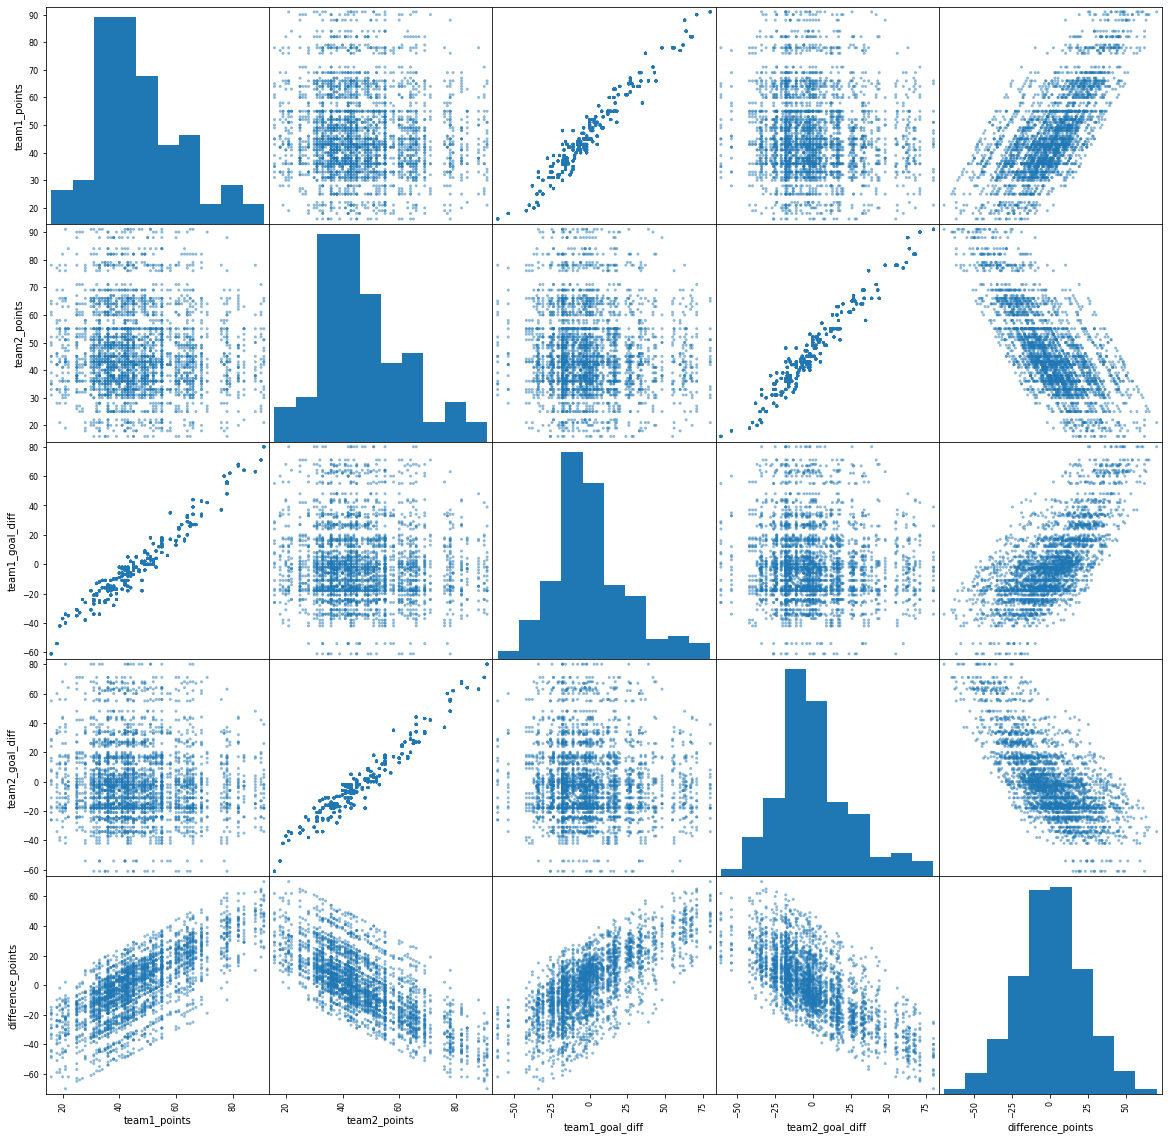

In [42]:
# Visualising distribution of data

scatter_matrix(df_r[['team1_points','team2_points','team1_goal_diff', 'team2_goal_diff', 'difference_points']], figsize=(20,20))

In [43]:
df_r = df_r.drop(['team1_goal_diff', 'team2_goal_diff', 'difference_points'], axis = 1)

# ML

In [44]:
data = df_r

In [45]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['result'],1)
y_all = data['result']

C:\Users\User\AppData\Local\Temp\ipykernel_58352\132493183.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_all = data.drop(['result'],1)


In [46]:
X_all = X_all.drop(['match_id', 'team1_id', 'team1_name', 'team2_id', 'team2_name', 'season', '2nd_ht_result_team1', '2nd_ht_result_team2', '1st_ht_result_team1', '1st_ht_result_team2', 'weekday', 'gameday'], axis = 1)

In [47]:
transformer = MinMaxScaler().fit(X_all)
X_all_scaled_arr = transformer.transform(X_all)
X_all_scaled = pd.DataFrame(X_all_scaled_arr, columns=X_all.columns)
X_all_scaled

,team1_points,team1_opponent_goals,team1_goals,team1_won_games,team1_lost_games,team1_draw,team2_points,team2_opponent_goals,team2_goals,team2_won_games,team2_lost_games,team2_draw
0,0.386667,0.637681,0.386667,0.346154,0.521739,0.500000,0.813333,0.289855,0.960000,0.807692,0.173913,0.166667
1,0.160000,0.521739,0.026667,0.076923,0.652174,0.833333,0.520000,0.420290,0.440000,0.461538,0.347826,0.583333
2,0.293333,0.565217,0.186667,0.269231,0.652174,0.416667,0.400000,0.623188,0.440000,0.384615,0.565217,0.333333
3,0.226667,0.608696,0.213333,0.153846,0.608696,0.750000,0.026667,0.942029,0.040000,0.000000,0.913043,0.500000
4,0.546667,0.391304,0.333333,0.500000,0.347826,0.500000,0.640000,0.434783,0.733333,0.615385,0.304348,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
3055,0.466667,0.420290,0.320000,0.423077,0.434783,0.500000,0.360000,0.507246,0.293333,0.269231,0.434783,0.833333
3056,0.373333,0.434783,0.186667,0.307692,0.478261,0.666667,0.240000,0.710145,0.333333,0.192308,0.652174,0.583333
3057,0.666667,0.362319,0.746667,0.615385,0.217391,0.500000,0.200000,0.724638,0.226667,0.192308,0.782609,0.333333
3058,0.360000,0.550725,0.160000,0.346154,0.608696,0.333333,0.346667,0.391304,0.226667,0.269231,0.478261,0.750000


In [48]:
# Train-Test-Split:

X_train, X_test, y_train, y_test = train_test_split(X_all_scaled, y_all, test_size=0.2, random_state=42)

In [49]:
classification = LogisticRegression(random_state=42, solver='saga', multi_class='multinomial').fit(X_train, y_train)

In [50]:
predictions = classification.predict(X_test)
predictions
classification.score(X_test, y_test)


0.5392156862745098

In [51]:
classification2 = SVC(random_state = 42, kernel='poly', C=2, gamma=2)
classification2 = classification2.fit(X_train, y_train)

In [52]:
predictions2 = classification2.predict(X_test)
predictions2
classification2.score(X_test, y_test)

0.5506535947712419

In [53]:
classification3 = xgb.XGBClassifier(n_estimators=2000, eta=0.01)
classification3 = classification3.fit(X_train, y_train)

In [54]:
predictions3 = classification3.predict(X_test)
predictions3
classification3.score(X_test, y_test)

0.48366013071895425

In [55]:
clf = RandomForestClassifier(max_depth=15,
                             min_samples_split=6,
                             min_samples_leaf =4,
                             max_samples=0.2,
                             random_state = None)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
display(y_test.value_counts())

0.6094771241830066
0.5163398692810458


0    267
1    174
2    171
Name: result, dtype: int64

In [56]:
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

In [57]:
# from sklearn.model_selection import GridSearchCV

# CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)

In [58]:
# CV_rfc.best_params_

In [59]:
clf = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=7, criterion='gini')

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
display(y_test.value_counts())

0.6474673202614379
0.5245098039215687


0    267
1    174
2    171
Name: result, dtype: int64

# Prepare future table for predictions

In [60]:
df.drop(df.tail(2).index,inplace=True)
df.head(18)

,team_id,team_name,points,opponent_goals,goals,matches,won_games,lost_games,draw,goal_diff,season
0,40,FC Bayern München,77,37,97,34,24,5,5,60,2021
1,7,Borussia Dortmund,69,52,85,34,22,9,3,33,2021
2,6,Bayer Leverkusen,64,47,80,34,19,8,7,33,2021
3,1635,RB Leipzig,58,37,72,34,17,10,7,35,2021
4,80,1. FC Union Berlin,57,44,50,34,16,9,9,6,2021
5,112,SC Freiburg,55,46,58,34,15,9,10,12,2021
6,65,1. FC Köln,52,49,52,34,14,10,10,3,2021
7,81,1. FSV Mainz 05,46,45,50,34,13,14,7,5,2021
8,175,TSG 1899 Hoffenheim,46,60,58,34,13,14,7,-2,2021
9,87,Borussia Mönchengladbach,45,61,54,34,12,13,9,-7,2021


In [61]:
df2.drop(df2.head(16).index,inplace=True)

In [62]:
df2.head(18)

,team_id,team_name,points,opponent_goals,goals,matches,won_games,lost_games,draw,goal_diff,season
16,134,Werder Bremen,31,57,36,34,7,17,10,-21,2020
17,9,FC Schalke 04,16,86,25,34,3,24,7,-61,2020


In [63]:
df2022 = pd.concat([df, df2], axis=0).reset_index()
df2022.head(18)

,index,team_id,team_name,points,opponent_goals,goals,matches,won_games,lost_games,draw,goal_diff,season
0,0,40,FC Bayern München,77,37,97,34,24,5,5,60,2021
1,1,7,Borussia Dortmund,69,52,85,34,22,9,3,33,2021
2,2,6,Bayer Leverkusen,64,47,80,34,19,8,7,33,2021
3,3,1635,RB Leipzig,58,37,72,34,17,10,7,35,2021
4,4,80,1. FC Union Berlin,57,44,50,34,16,9,9,6,2021
5,5,112,SC Freiburg,55,46,58,34,15,9,10,12,2021
6,6,65,1. FC Köln,52,49,52,34,14,10,10,3,2021
7,7,81,1. FSV Mainz 05,46,45,50,34,13,14,7,5,2021
8,8,175,TSG 1899 Hoffenheim,46,60,58,34,13,14,7,-2,2021
9,9,87,Borussia Mönchengladbach,45,61,54,34,12,13,9,-7,2021


In [64]:
s2022 = s2

In [65]:
df2022 = df2022.drop(['team_name', 'matches', 'season'], axis = 1)

In [66]:
s2022.head(18)

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season
0,58577,4,1,40,FC Bayern München,9,FC Schalke 04,8,0,3,0,2020
1,58579,5,1,91,Eintracht Frankfurt,83,Arminia Bielefeld,1,1,0,0,2020
2,58580,5,1,65,1. FC Köln,175,TSG 1899 Hoffenheim,2,3,1,2,2020
3,58582,5,1,16,VfB Stuttgart,112,SC Freiburg,2,3,0,2,2020
4,58583,5,1,80,1. FC Union Berlin,95,FC Augsburg,1,3,0,1,2020
5,58584,5,1,134,Werder Bremen,54,Hertha BSC,1,4,0,1,2020
6,58578,5,1,7,Borussia Dortmund,87,Borussia Mönchengladbach,3,0,1,0,2020
7,58581,6,1,1635,RB Leipzig,81,1. FSV Mainz 05,3,1,2,0,2020
8,58585,6,1,131,VfL Wolfsburg,6,Bayer Leverkusen,0,0,0,0,2020
9,58591,4,2,54,Hertha BSC,91,Eintracht Frankfurt,1,3,0,2,2020


In [67]:
s2022['team1_id'].replace(83, 
           129, 
           inplace=True)
s2022['team2_id'].replace(83, 
           129, 
           inplace=True)
s2022['team1_name'].replace("Arminia Bielefeld", 
           "VfL Bochum", 
           inplace=True)
s2022['team2_name'].replace("Arminia Bielefeld", 
           "VfL Bochum", 
           inplace=True)

In [68]:
s2022.head(18)

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season
0,58577,4,1,40,FC Bayern München,9,FC Schalke 04,8,0,3,0,2020
1,58579,5,1,91,Eintracht Frankfurt,129,VfL Bochum,1,1,0,0,2020
2,58580,5,1,65,1. FC Köln,175,TSG 1899 Hoffenheim,2,3,1,2,2020
3,58582,5,1,16,VfB Stuttgart,112,SC Freiburg,2,3,0,2,2020
4,58583,5,1,80,1. FC Union Berlin,95,FC Augsburg,1,3,0,1,2020
5,58584,5,1,134,Werder Bremen,54,Hertha BSC,1,4,0,1,2020
6,58578,5,1,7,Borussia Dortmund,87,Borussia Mönchengladbach,3,0,1,0,2020
7,58581,6,1,1635,RB Leipzig,81,1. FSV Mainz 05,3,1,2,0,2020
8,58585,6,1,131,VfL Wolfsburg,6,Bayer Leverkusen,0,0,0,0,2020
9,58591,4,2,54,Hertha BSC,91,Eintracht Frankfurt,1,3,0,2,2020


In [69]:
s2022 = pd.merge(left = s2022,
             right = df2022,
             how = 'left', 
             left_on = "team1_id", 
             right_on= "team_id")

s2022 = pd.merge(left = s2022,
             right = df2022,
             how = 'left', 
             left_on = "team2_id", 
             right_on= "team_id")

In [70]:
s2022

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season,index_x,team_id_x,points_x,opponent_goals_x,goals_x,won_games_x,lost_games_x,draw_x,goal_diff_x,index_y,team_id_y,points_y,opponent_goals_y,goals_y,won_games_y,lost_games_y,draw_y,goal_diff_y
0,58577,4,1,40,FC Bayern München,9,FC Schalke 04,8,0,3,0,2020,0,40,77,37,97,24,5,5,60,17,9,16,86,25,3,24,7,-61
1,58579,5,1,91,Eintracht Frankfurt,129,VfL Bochum,1,1,0,0,2020,10,91,42,49,45,10,12,12,-4,12,129,42,52,38,12,16,6,-14
2,58580,5,1,65,1. FC Köln,175,TSG 1899 Hoffenheim,2,3,1,2,2020,6,65,52,49,52,14,10,10,3,8,175,46,60,58,13,14,7,-2
3,58582,5,1,16,VfB Stuttgart,112,SC Freiburg,2,3,0,2,2020,14,16,33,59,41,7,15,12,-18,5,112,55,46,58,15,9,10,12
4,58583,5,1,80,1. FC Union Berlin,95,FC Augsburg,1,3,0,1,2020,4,80,57,44,50,16,9,9,6,13,95,38,56,39,10,16,8,-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,58881,5,34,65,1. FC Köln,9,FC Schalke 04,1,0,0,0,2020,6,65,52,49,52,14,10,10,3,17,9,16,86,25,3,24,7,-61
302,58882,5,34,16,VfB Stuttgart,129,VfL Bochum,0,2,0,0,2020,14,16,33,59,41,7,15,12,-18,12,129,42,52,38,12,16,6,-14
303,58883,5,34,80,1. FC Union Berlin,1635,RB Leipzig,2,1,0,0,2020,4,80,57,44,50,16,9,9,6,3,1635,58,37,72,17,10,7,35
304,58884,5,34,134,Werder Bremen,87,Borussia Mönchengladbach,2,4,0,1,2020,16,134,31,57,36,7,17,10,-21,9,87,45,61,54,12,13,9,-7


In [71]:
s2022 = s2022.drop(['index_x', 'index_y', 'team_id_x', 'team_id_y'], axis = 1)
s2022 = s2022.rename(columns={ "points_x": "team1_points", "points_y": "team2_points", "opponent_goals_x": "team1_opponent_goals", "opponent_goals_y": "team2_opponent_goals", "goals_x": "team1_goals", "goals_y": "team2_goals", "won_games_x": "team1_won_games", "won_games_y": "team2_won_games", "lost_games_x": "team1_lost_games", "lost_games_y": "team2_lost_games", "draw_x": "team1_draw", "draw_y": "team2_draw", "goal_diff_x": "team1_goal_diff", "goal_diff_y": "team2_goal_diff"})

In [72]:
s2022 = s2022.drop(['team1_goal_diff', 'team2_goal_diff'], axis = 1)

In [73]:
X_2022_pred = s2022.drop(['match_id', 'team1_id', 'team1_name', 'team2_id', 'team2_name', 'season', '2nd_ht_result_team1', '2nd_ht_result_team2', '1st_ht_result_team1', '1st_ht_result_team2', 'weekday', 'gameday'], axis = 1)

In [74]:
X_2022_scaled_arr = transformer.transform(X_2022_pred)
X_2022_scaled = pd.DataFrame(X_2022_scaled_arr, columns=X_2022_pred.columns)
X_2022_scaled

,team1_points,team1_opponent_goals,team1_goals,team1_won_games,team1_lost_games,team1_draw,team2_points,team2_opponent_goals,team2_goals,team2_won_games,team2_lost_games,team2_draw
0,0.813333,0.289855,0.960000,0.807692,0.173913,0.166667,0.000000,1.000000,0.000000,0.000000,1.000000,0.333333
1,0.346667,0.463768,0.266667,0.269231,0.478261,0.750000,0.346667,0.507246,0.173333,0.346154,0.652174,0.250000
2,0.480000,0.463768,0.360000,0.423077,0.391304,0.583333,0.400000,0.623188,0.440000,0.384615,0.565217,0.333333
3,0.226667,0.608696,0.213333,0.153846,0.608696,0.750000,0.520000,0.420290,0.440000,0.461538,0.347826,0.583333
4,0.546667,0.391304,0.333333,0.500000,0.347826,0.500000,0.293333,0.565217,0.186667,0.269231,0.652174,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.480000,0.463768,0.360000,0.423077,0.391304,0.583333,0.000000,1.000000,0.000000,0.000000,1.000000,0.333333
302,0.226667,0.608696,0.213333,0.153846,0.608696,0.750000,0.346667,0.507246,0.173333,0.346154,0.652174,0.250000
303,0.546667,0.391304,0.333333,0.500000,0.347826,0.500000,0.560000,0.289855,0.626667,0.538462,0.391304,0.333333
304,0.200000,0.579710,0.146667,0.153846,0.695652,0.583333,0.386667,0.637681,0.386667,0.346154,0.521739,0.500000


In [75]:
# LogReg
predictions = classification.predict(X_2022_scaled)
predictions

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       2, 1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 2,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 2,
       2, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0,

In [76]:
l_22 = pd.DataFrame(predictions)
l_22 = l_22.rename(columns={ 0: "lr_result_prediction_2022"})
l_22

,lr_result_prediction_2022
0,0
1,0
2,0
3,1
4,0
...,...
301,0
302,2
303,0
304,1


In [77]:
# SVC
predictions2 = classification2.predict(X_2022_scaled)
predictions2
# classification2.score(X_test, y_test)

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 2, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 2,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 0,

In [78]:
resu = pd.DataFrame(predictions2)
resu = resu.rename(columns={ 0: "svc_result_prediction_2022"})
resu

,svc_result_prediction_2022
0,0
1,0
2,0
3,1
4,0
...,...
301,0
302,0
303,0
304,1


In [79]:
# predictions with XGB
predictions3 = classification3.predict(X_2022_scaled)
x22 = pd.DataFrame(predictions3)
x22 = x22.rename(columns={ 0: "xgb_result_prediction_2022"})
x22

,xgb_result_prediction_2022
0,0
1,0
2,1
3,1
4,0
...,...
301,0
302,2
303,0
304,2


In [80]:
y_pred = clf.predict(X_2022_scaled)
p22 = pd.DataFrame(y_pred)
p22 = p22.rename(columns={ 0: "rfc_result_prediction_2022"})
p22

,rfc_result_prediction_2022
0,0
1,0
2,0
3,1
4,0
...,...
301,0
302,2
303,0
304,2


In [81]:
df_r_2022 = pd.concat([s2022, l_22, resu, x22, p22], axis=1).reset_index()
df_r_2022 = df_r_2022.drop(['index', 'match_id', 'weekday', 'gameday', 'season', '2nd_ht_result_team1', '2nd_ht_result_team2', '1st_ht_result_team1', '1st_ht_result_team2', 'team1_points', 'team1_opponent_goals', 'team1_goals', 'team1_won_games', 'team1_lost_games', 'team1_draw', 'team2_points', 'team2_opponent_goals', 'team2_goals', 'team2_won_games', 'team2_lost_games', 'team2_draw'], axis = 1)
df_r_2022.head(18)

,team1_id,team1_name,team2_id,team2_name,lr_result_prediction_2022,svc_result_prediction_2022,xgb_result_prediction_2022,rfc_result_prediction_2022
0,40,FC Bayern München,9,FC Schalke 04,0,0,0,0
1,91,Eintracht Frankfurt,129,VfL Bochum,0,0,0,0
2,65,1. FC Köln,175,TSG 1899 Hoffenheim,0,0,1,0
3,16,VfB Stuttgart,112,SC Freiburg,1,1,1,1
4,80,1. FC Union Berlin,95,FC Augsburg,0,0,0,0
5,134,Werder Bremen,54,Hertha BSC,0,0,2,2
6,7,Borussia Dortmund,87,Borussia Mönchengladbach,0,0,0,0
7,1635,RB Leipzig,81,1. FSV Mainz 05,0,0,0,0
8,131,VfL Wolfsburg,6,Bayer Leverkusen,1,1,1,1
9,54,Hertha BSC,91,Eintracht Frankfurt,1,2,2,2


In [82]:
df_r_2022.tail(18)

,team1_id,team1_name,team2_id,team2_name,lr_result_prediction_2022,svc_result_prediction_2022,xgb_result_prediction_2022,rfc_result_prediction_2022
288,129,VfL Bochum,175,TSG 1899 Hoffenheim,0,0,1,1
289,95,FC Augsburg,134,Werder Bremen,0,0,1,2
290,6,Bayer Leverkusen,80,1. FC Union Berlin,0,0,2,0
291,87,Borussia Mönchengladbach,16,VfB Stuttgart,0,0,2,0
292,112,SC Freiburg,40,FC Bayern München,1,1,1,1
293,54,Hertha BSC,65,1. FC Köln,1,1,1,1
294,9,FC Schalke 04,91,Eintracht Frankfurt,1,1,1,1
295,81,1. FSV Mainz 05,7,Borussia Dortmund,1,1,1,1
296,1635,RB Leipzig,131,VfL Wolfsburg,0,0,0,0
297,40,FC Bayern München,95,FC Augsburg,0,0,0,0


In [83]:
df_r_2022.to_excel(r'result_2022.xlsx', index = False)

In [84]:
df2022.to_excel(r'table_2022.xlsx', index = False)

In [85]:
import sys
sys.exit("Error message")

SystemExit: Error message

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3259: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


predicting results 2021

In [ ]:

link = 'https://www.openligadb.de/api/getbltable/bl1/2021'
response = requests.get(link)
t_2021 = response.json()

df = pd.DataFrame(t_2021)

df = df.drop(['ShortName', 'TeamIconUrl'], axis = 1)
df = df.rename(columns={ "TeamInfoId": "team_id", "TeamName": "team_name", "Points": "points", "OpponentGoals": "opponent_goals", "Goals": "goals", "Matches": "matches", "Won": "won_games", "Lost": "lost_games", "Draw": "draw", "GoalDiff": "goal_diff"})
df.drop(['team_name', 'matches'], axis = 1)
df.head(18)


,team_id,team_name,points,opponent_goals,goals,matches,won_games,lost_games,draw,goal_diff
0,40,FC Bayern München,77,37,97,34,24,5,5,60
1,7,Borussia Dortmund,69,52,85,34,22,9,3,33
2,6,Bayer Leverkusen,64,47,80,34,19,8,7,33
3,1635,RB Leipzig,58,37,72,34,17,10,7,35
4,80,1. FC Union Berlin,57,44,50,34,16,9,9,6
5,112,SC Freiburg,55,46,58,34,15,9,10,12
6,65,1. FC Köln,52,49,52,34,14,10,10,3
7,81,1. FSV Mainz 05,46,45,50,34,13,14,7,5
8,175,TSG 1899 Hoffenheim,46,60,58,34,13,14,7,-2
9,87,Borussia Mönchengladbach,45,61,54,34,12,13,9,-7


In [ ]:
s

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season
0,60845,4,1,87,Borussia Mönchengladbach,40,FC Bayern München,1,1,1,1,2021
1,60846,5,1,83,Arminia Bielefeld,112,SC Freiburg,0,0,0,0,2021
2,60847,5,1,95,FC Augsburg,175,TSG 1899 Hoffenheim,0,4,0,1,2021
3,60851,5,1,16,VfB Stuttgart,115,SpVgg Greuther Fürth,5,1,2,0,2021
4,60852,5,1,80,1. FC Union Berlin,6,Bayer Leverkusen,1,1,1,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
301,61146,5,34,87,Borussia Mönchengladbach,175,TSG 1899 Hoffenheim,5,1,3,1,2021
302,61147,5,34,81,1. FSV Mainz 05,91,Eintracht Frankfurt,2,2,1,2,2021
303,61148,5,34,16,VfB Stuttgart,65,1. FC Köln,2,1,1,0,2021
304,61149,5,34,80,1. FC Union Berlin,129,VfL Bochum,3,2,2,0,2021


In [ ]:
s2021 = pd.merge(left = s,
             right = df,
             how = 'left', 
             left_on = "team1_id", 
             right_on= "team_id")
s2021 = pd.merge(left = s2021,
             right = df,
             how = 'left', 
             left_on = "team2_id", 
             right_on= "team_id")

In [ ]:
s2021

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season,team_id_x,team_name_x,points_x,opponent_goals_x,goals_x,matches_x,won_games_x,lost_games_x,draw_x,goal_diff_x,team_id_y,team_name_y,points_y,opponent_goals_y,goals_y,matches_y,won_games_y,lost_games_y,draw_y,goal_diff_y
0,60845,4,1,87,Borussia Mönchengladbach,40,FC Bayern München,1,1,1,1,2021,87,Borussia Mönchengladbach,45,61,54,34,12,13,9,-7,40,FC Bayern München,77,37,97,34,24,5,5,60
1,60846,5,1,83,Arminia Bielefeld,112,SC Freiburg,0,0,0,0,2021,83,Arminia Bielefeld,28,53,27,34,5,16,13,-26,112,SC Freiburg,55,46,58,34,15,9,10,12
2,60847,5,1,95,FC Augsburg,175,TSG 1899 Hoffenheim,0,4,0,1,2021,95,FC Augsburg,38,56,39,34,10,16,8,-17,175,TSG 1899 Hoffenheim,46,60,58,34,13,14,7,-2
3,60851,5,1,16,VfB Stuttgart,115,SpVgg Greuther Fürth,5,1,2,0,2021,16,VfB Stuttgart,33,59,41,34,7,15,12,-18,115,SpVgg Greuther Fürth,18,82,28,34,3,22,9,-54
4,60852,5,1,80,1. FC Union Berlin,6,Bayer Leverkusen,1,1,1,1,2021,80,1. FC Union Berlin,57,44,50,34,16,9,9,6,6,Bayer Leverkusen,64,47,80,34,19,8,7,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,61146,5,34,87,Borussia Mönchengladbach,175,TSG 1899 Hoffenheim,5,1,3,1,2021,87,Borussia Mönchengladbach,45,61,54,34,12,13,9,-7,175,TSG 1899 Hoffenheim,46,60,58,34,13,14,7,-2
302,61147,5,34,81,1. FSV Mainz 05,91,Eintracht Frankfurt,2,2,1,2,2021,81,1. FSV Mainz 05,46,45,50,34,13,14,7,5,91,Eintracht Frankfurt,42,49,45,34,10,12,12,-4
303,61148,5,34,16,VfB Stuttgart,65,1. FC Köln,2,1,1,0,2021,16,VfB Stuttgart,33,59,41,34,7,15,12,-18,65,1. FC Köln,52,49,52,34,14,10,10,3
304,61149,5,34,80,1. FC Union Berlin,129,VfL Bochum,3,2,2,0,2021,80,1. FC Union Berlin,57,44,50,34,16,9,9,6,129,VfL Bochum,42,52,38,34,12,16,6,-14


In [ ]:
s2021 = s2021.drop(['team_id_x', 'team_id_y', 'team_name_x', 'team_name_y', 'matches_x', 'matches_y'], axis = 1)
s2021 = s2021.rename(columns={ "points_x": "team1_points", "points_y": "team2_points", "opponent_goals_x": "team1_opponent_goals", "opponent_goals_y": "team2_opponent_goals", "goals_x": "team1_goals", "goals_y": "team2_goals", "won_games_x": "team1_won_games", "won_games_y": "team2_won_games", "lost_games_x": "team1_lost_games", "lost_games_y": "team2_lost_games", "draw_x": "team1_draw", "draw_y": "team2_draw", "goal_diff_x": "team1_goal_diff", "goal_diff_y": "team2_goal_diff"})

In [ ]:
s2021 = s2021.drop(['team1_goal_diff', 'team2_goal_diff'], axis = 1)

In [ ]:
X_2021_pred = s2021.drop(['match_id', 'team1_id', 'team1_name', 'team2_id', 'team2_name', 'season', '2nd_ht_result_team1', '2nd_ht_result_team2', '1st_ht_result_team1', '1st_ht_result_team2', 'weekday', 'gameday'], axis = 1)

In [ ]:
X_2021_scaled_arr = transformer.transform(X_2021_pred)
X_2021_scaled = pd.DataFrame(X_2021_scaled_arr, columns=X_2021_pred.columns)
X_2021_scaled

,team1_points,team1_opponent_goals,team1_goals,team1_won_games,team1_lost_games,team1_draw,team2_points,team2_opponent_goals,team2_goals,team2_won_games,team2_lost_games,team2_draw
0,0.386667,0.637681,0.386667,0.346154,0.521739,0.500000,0.813333,0.289855,0.960000,0.807692,0.173913,0.166667
1,0.160000,0.521739,0.026667,0.076923,0.652174,0.833333,0.520000,0.420290,0.440000,0.461538,0.347826,0.583333
2,0.293333,0.565217,0.186667,0.269231,0.652174,0.416667,0.400000,0.623188,0.440000,0.384615,0.565217,0.333333
3,0.226667,0.608696,0.213333,0.153846,0.608696,0.750000,0.026667,0.942029,0.040000,0.000000,0.913043,0.500000
4,0.546667,0.391304,0.333333,0.500000,0.347826,0.500000,0.640000,0.434783,0.733333,0.615385,0.304348,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.386667,0.637681,0.386667,0.346154,0.521739,0.500000,0.400000,0.623188,0.440000,0.384615,0.565217,0.333333
302,0.400000,0.405797,0.333333,0.384615,0.565217,0.333333,0.346667,0.463768,0.266667,0.269231,0.478261,0.750000
303,0.226667,0.608696,0.213333,0.153846,0.608696,0.750000,0.480000,0.463768,0.360000,0.423077,0.391304,0.583333
304,0.546667,0.391304,0.333333,0.500000,0.347826,0.500000,0.346667,0.507246,0.173333,0.346154,0.652174,0.250000


In [ ]:
# SVC
predictions2 = classification2.predict(X_2021_scaled)
predictions2
# classification2.score(X_test, y_test)

array([1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 1, 0, 0, 2, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 0,
       2, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 1, 1,
       2, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 2, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0,
       0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1,
       1, 0, 2, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0,

In [ ]:
res_21 = pd.DataFrame(predictions2)
res_21 = res_21.rename(columns={ 0: "svc_result_prediction_2021"})
res_21

,svc_result_prediction_2021
0,1
1,2
2,1
3,2
4,0
...,...
301,0
302,2
303,2
304,0


In [ ]:
# predictions with RandomForestClassifier
y_pred = clf.predict(X_2021_scaled)
p21 = pd.DataFrame(y_pred)
p21 = p21.rename(columns={ 0: "rfc_result_prediction_2021"})
p21

,rfc_result_prediction_2021
0,1
1,1
2,1
3,0
4,1
...,...
301,0
302,2
303,1
304,0


In [ ]:
# predictions with XGB
predictions3 = classification3.predict(X_2021_scaled)
x21 = pd.DataFrame(predictions3)
x21 = x21.rename(columns={ 0: "xgb_result_prediction_2021"})
x21

,xgb_result_prediction_2021
0,1
1,1
2,1
3,2
4,1
...,...
301,0
302,2
303,1
304,0


In [ ]:
# 0 = home team wins | 1 = home team loses | 2 = draw

In [ ]:
# df_r.drop(df_r.tail(2754).index,inplace=True)
# df_r
s2021['result'] = s2021.apply(res, axis=1)
s2021

,match_id,weekday,gameday,team1_id,team1_name,team2_id,team2_name,2nd_ht_result_team1,2nd_ht_result_team2,1st_ht_result_team1,1st_ht_result_team2,season,team1_points,team1_opponent_goals,team1_goals,team1_won_games,team1_lost_games,team1_draw,team2_points,team2_opponent_goals,team2_goals,team2_won_games,team2_lost_games,team2_draw,result
0,60845,4,1,87,Borussia Mönchengladbach,40,FC Bayern München,1,1,1,1,2021,45,61,54,12,13,9,77,37,97,24,5,5,2
1,60846,5,1,83,Arminia Bielefeld,112,SC Freiburg,0,0,0,0,2021,28,53,27,5,16,13,55,46,58,15,9,10,2
2,60847,5,1,95,FC Augsburg,175,TSG 1899 Hoffenheim,0,4,0,1,2021,38,56,39,10,16,8,46,60,58,13,14,7,1
3,60851,5,1,16,VfB Stuttgart,115,SpVgg Greuther Fürth,5,1,2,0,2021,33,59,41,7,15,12,18,82,28,3,22,9,0
4,60852,5,1,80,1. FC Union Berlin,6,Bayer Leverkusen,1,1,1,1,2021,57,44,50,16,9,9,64,47,80,19,8,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,61146,5,34,87,Borussia Mönchengladbach,175,TSG 1899 Hoffenheim,5,1,3,1,2021,45,61,54,12,13,9,46,60,58,13,14,7,0
302,61147,5,34,81,1. FSV Mainz 05,91,Eintracht Frankfurt,2,2,1,2,2021,46,45,50,13,14,7,42,49,45,10,12,12,2
303,61148,5,34,16,VfB Stuttgart,65,1. FC Köln,2,1,1,0,2021,33,59,41,7,15,12,52,49,52,14,10,10,0
304,61149,5,34,80,1. FC Union Berlin,129,VfL Bochum,3,2,2,0,2021,57,44,50,16,9,9,42,52,38,12,16,6,0


In [ ]:
df_r_2021 = pd.concat([s2021, l_21, res_21, p21, x21], axis=1).reset_index()

In [ ]:
df_r_2021.to_excel(r'table_2021.xlsx', index = False)